In [4]:
# !pip install atpbar
# !pip install ipywidgets 
# !pip install nodejs
# !pip install numpy
# !pip install matplotlib
import numpy as np
import numpy.matlib
import random
from heapq import merge
import math as m
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
from atpbar import atpbar
from itertools import groupby
import sys
old_stdout = sys.stdout
sys.stdout = open('stdout.txt', 'w')
sys.stdout = old_stdout
# import matlab

print('-----------------------')
print('LoRa simulator V 1.02')
print('Author: René Brandborg Sørensen')
print('Email1: rbs@es.aau.dk')
print('Email2: madwarRBS@gmail.com')
print('-----------------------')
print('Features:')
print('+ indicates integrated features')
print('- indicates possible extensions')
print('-----------------------')
print('Uplink transmission: ')
print('+Aggregated duty-cycling')
print('+Regulatory duty-cycling')
print('+Co-SF and Inter-SF interference ')
print('+AP demodulation paths paths ')
print('+Packet fragmentation')
print('+Acknowledgements')
print('-----------------------')
print('Downlink transmission: ')
print('+Scheduled DL tx')
print('-Packet fragmentation')
print('+Receive window 1 and 2')
print('+Class A and C')
print('-Acknowledgements')
print('-----------------------')

-----------------------
LoRa simulator V 1.02
Author: René Brandborg Sørensen
Email1: rbs@es.aau.dk
Email2: madwarRBS@gmail.com
-----------------------
Features:
+ indicates integrated features
- indicates possible extensions
-----------------------
Uplink transmission: 
+Aggregated duty-cycling
+Regulatory duty-cycling
+Co-SF and Inter-SF interference 
+AP demodulation paths paths 
+Packet fragmentation
+Acknowledgements
-----------------------
Downlink transmission: 
+Scheduled DL tx
-Packet fragmentation
+Receive window 1 and 2
+Class A and C
-Acknowledgements
-----------------------


In [738]:
def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    try:
        a = max(len_iter(run) for val, run in groupby(data) if val)
    except:
        a = 0
    return a

def db2pow(xdb):
    """Convert decibels (dB) to power

    .. doctest::

        >>> p = db2pow(-10)
        >>> p
        0.1

    .. seealso:: :func:`pow2db`
    """
    try:
        res = 10.**(xdb/10.)
    except:
        res = [10.**(i/10.) for i in xdb]    
    return res

def pow2db(xpow):
    """Convert decibels (dB) to power

    .. doctest::
        >>> import math as m
        >>> db = pow2db(.1)
        >>> db
        -10

    .. seealso:: :func:`db2pow`
    """
    try:
        res = m.log10(xpow)*10
    except:
        res = [m.log10(i)*10 for i in xdb]    
    return res


#### Parameters ####
class params:
    """
    Parameters for the Simulation
    """
    def __init__(self):
        1
    
    maxReports = 20
    queueLength = 0
    REPS = 10
    simulationLen = 3600*2 # simulation length in seconds

    class system:
        M = 1000 # number of devices
        A = 5 # Number of access points
        cellRadius = 1000 # cell radius in meters
        r = [0,1] # adefault UL subbands
        rAP = [4] # default DL subband
        APdmodpaths = 8
        devdmodpaths = 1
        centeredAP = 1
        rdmAPuniform = 0
        distSF=0
        rdmSFuni=1
    
    class modules:
        capture = 1
        ULDL_SIC = 0 # DL interfers with UL
    
    class traffic:
        periodic = 0 # indicates that the traffic is quasi-peridic
        offset = 1
        jitter = 0
        
        poisson = 1 # indicates that the traffic is poisson-type
        lambdaD = 1/(60*10) # arrival rate for a single device
        
        exception = 0 # indicates that the traffic is exception-type
        alpha = 3
        beta = 4
        period = 5*60 # alarm periodi n secs
        
        payload = [40, 40, 40, 40, 40, 40] # Payload in bytes for different SFs
        nTX = 1 # no. transmission attempts
        lSF = []
    
    class channel:
        alpha = 4
        raygain = 1
        noisePower = 0 
        
    class lora:
        M = [i for i in range(7,12+1)] # spreading factors
        N = [222, 222, 115, 51, 51, 51] # Max no. payload bytes per transmission for each SF
        overhead = 8 # bytes of LoRaMAC overhead
        npreamble = 8 # symbols in preamble
        fragments = []
        modulos = []
        
        
        CR = 1 # coding rate
        DE = [0,0,0,0,1,1] # data rate optimization
        
        fc = 868 # Carrier frequency in hertz
        BW = 125*10**3 # Channel bandwidth in hertz
        chs = [5, 3, 2, 1, 1] # channels in sub-bands (max is 8 channels, max per band is [15, 3, 2, 1, 1])
        d = [0.01, 0.01, 0.001, 0.1, 1] # duty-cycle of sub-bands
        
        dev_P0 = db2pow(14-30) # tx power
        AP_P0 = db2pow(14-30) # tx power
        NF = 0 # noise figure in dB
        
        
        gamma_co = db2pow([6, 6, 6, 6, 6, 6]) # SF co_interference capture thresholds
        gamma_int = db2pow([-7.5,-9,-13.5,-15,-18,-22.5]) # SF inter_interference capture thresholds
        gamma_rx = db2pow([-6, -9, -12, -15, -17.5, -20]) # SF capture thresholds (smallest SNR)
        rxSens = db2pow(np.array([-126.5, -129, -131.5, -134, -136.5, -139.5])-30) # Reception sensitivity (smallest power)
        # rxSens = db2pow([-123, -126, -129, -132, -134.5, -137]-30)
        # rxSens = db2pow([-126.5, -129, -131.5, -134, -136.5, -139.5]-30)
        
        
Parameters = params()
# Parameters.traffic.payload = [223, 223, 116, 52, 52, 52] # [222, 222, 115, 51, 51, 51]
Parameters.queueLength = Parameters.maxReports
Parameters.lora.fragments = [min(np.ceil(Parameters.traffic.payload[i]/Parameters.lora.N[i]),1) for i in range(0,len(Parameters.lora.M))]
Parameters.lora.modulos = [np.mod(Parameters.traffic.payload[i],Parameters.lora.N[i]) for i in range(0,len(Parameters.lora.M))]
Parameters.channel.noisePower = db2pow((-174 + Parameters.lora.NF + 10*m.log10(Parameters.lora.BW))-30)
Parameters.lora.tSymbol = [2**SF/Parameters.lora.BW for SF in Parameters.lora.M] #tx time for symbols
Parameters.lora.tPreamble = [(Parameters.lora.npreamble+4.25)*tS for tS in Parameters.lora.tSymbol]


# Spreading Factor Allocation
Parameters.traffic.lSF = [0]
Parameters.traffic.lSF.extend([((Parameters.lora.dev_P0*((Parameters.lora.fc**2)*10**(-2.8))**(-1))/i)**(1/Parameters.channel.alpha) for i in Parameters.lora.rxSens] )
Parameters.traffic.lSF = Parameters.traffic.lSF/max(Parameters.traffic.lSF)*Parameters.system.cellRadius

if(sum([Parameters.lora.chs[i] for i in Parameters.system.r])>8):
    print('AP can not handle more than 8 channels')
print('Parameters loaded')

# Define UE and AP structs
class subband:
    def __init__(self,local_parameters,sidx,i):
        self.channels = local_parameters.lora.chs[sidx[i]]
        self.dutycycle = local_parameters.lora.d[sidx[i]]
        self.txs = 0
        self.extrawork = 0
        self.queueLen = 0
        self.timeleft = 0

class UE:
    def __init__(self,local_parameters):
#         numberUEs = local_parameters.system.M;
        numberAPs = local_parameters.system.A;
        sidx = local_parameters.system.r
        
        self.r = sidx
        # system
        self.SB = [subband(local_parameters,sidx,i) for i in range(0,len(sidx))]
        self.demodpaths = local_parameters.system.devdmodpaths
        self.demodQ = 0
        self.aggDutycycle = 1
        self.TXpow = local_parameters.lora.dev_P0
        self.dist = np.zeros((1,numberAPs))
        self.pos = [0,0]
        self.pow = local_parameters.lora.dev_P0
        self.SF = 0
        self.RECEIVE_DELAY1 = 1
        self.RECEIVE_DELAY2 = 2
        self.RX1DROffset = 0
        self.RX2DR = 12
        
        # reporting
        self.reportIndex = 0
        self.reportNFragments = np.zeros(local_parameters.maxReports)
        self.reportNTX = np.zeros((int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportArrival = np.zeros((1,local_parameters.maxReports))
        self.reportArrivalType = np.matlib.repmat('N',1,local_parameters.maxReports)
        self.nextTX = 0
        self.reportSubband = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportChannel = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportDebug = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportModulos = np.zeros(local_parameters.maxReports)
        
        
        self.reportCapture = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportSucces = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailSnr = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailCoInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailInterInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailDemod = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailSens = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        
        self.reportPreSucces = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailCap = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailSnr = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailCoInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailInterInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailJointInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailDemod = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
#         self.reportFade = np.zeros((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports,numberAPs))
#     
#     
#     reportFragments = ones(1,Params.maxReports)
#     reportModulos = zeros(1,Params.maxReports)
#     reportFade = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
    
#     reportStart = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportFailSens = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportFailCoInt = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportFailInterInt = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportFailDemod = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportAggDelay = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportRegDelay = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDebug = -ones(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     nTX = zeros(1,Params.maxReports)
#     reportFinal = zeros(1,Params.maxReports)
#     reportDL = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDLtime = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlFragments = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlModulos = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlSucces = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlFailSens = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlFailCoInt = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlFailInterInt = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportDlRXW = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     reportAck = zeros(Params.traffic.nTX,max(Params.lora.fragments),Params.maxReports,numberAPs)
#     RX2bandch = [5, 1]
#     RECEIVE_DELAY1 = 1
#     RECEIVE_DELAY2 = 2
#     RX1DROffset = 0
#     RX2DR = 12
#     
#     
#     SB = repmat(subband,1,5)
#     aggWait = 0
#     pos = [0,0]
#     dist = zeros(1,numberAPs)
#     PL = zeros(1,numberAPs)
#     TXpow = Params.lora.P0
#     Dclass = 'a'
#     ack = 0
#     mainAP = 0
#     SF = 0

class AP:

    def __init__(self,local_parameters):
#         numberUEs = local_parameters.system.M;
#         numberAPs = local_parameters.system.A;
        self.demodpaths = local_parameters.system.APdmodpaths
        self.TXpow = local_parameters.lora.AP_P0
        self.r = local_parameters.system.rAP
        sbs = list(set(local_parameters.system.r) | set(local_parameters.system.rAP))
        self.SB = [subband(local_parameters,sbs,i) for i in range(0,len(sbs))]
        
        # reporting
        self.reportIndex = 0
        self.reportuID = np.zeros(local_parameters.maxReports)
        self.reportNFragments = np.zeros(local_parameters.maxReports)
        self.reportNTX = np.zeros((int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportArrival = np.zeros((1,local_parameters.maxReports))
        self.reportArrivalType = np.matlib.repmat('N',1,local_parameters.maxReports)
        self.nextTX = 0
        self.reportSubband = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportChannel = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportDebug = -1*np.ones((local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        self.reportModulos = np.zeros(local_parameters.maxReports)
        
        self.demodQ = 0
        self.pos = [0,0]
        self.pow = local_parameters.lora.AP_P0
        
        self.reportSucces = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailSnr = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailCoInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailInterInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailDemod = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        
        self.reportPreSucces = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportFailSens = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailSnr = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailCoInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailInterInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailJointInt = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
        self.reportPreFailDemod = [[[[] for _ in range(0,local_parameters.traffic.nTX)] for _ in range(0,int(max(local_parameters.lora.fragments)))] for _ in range(0,local_parameters.maxReports)]
    
# a = AP(Parameters)
# print(a.SB[2].channels)
    

Parameters loaded


[0.251188643150958, 0.12589254117941673, 0.06309573444801933, 0.03162277660168379, 0.01778279410038923, 0.01]
600.0


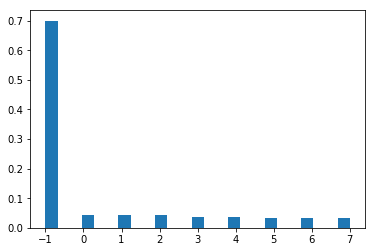

In [663]:
# gamma_co 
# gamma_int
print(Parameters.lora.gamma_rx)
print(1/Parameters.traffic.lambdaD)
plt.figure()
distances = ([i for j in UEs for i in j.reportChannel[0][0]])
y,x = np.histogram(distances,25)
plt.bar(x[0:-1]+(x[1]-x[0])/2,y/sum(y),width=(x[1]-x[0]))
plt.show()

In [345]:
def SpatialModel_uni(radiusCell,N):

    angles = np.random.rand(1,N)*2*np.pi
    radius = np.sqrt(radiusCell**2*(np.random.rand(1,N)))
    x = radius*np.cos(angles)
    y = radius*np.sin(angles)
    p = [x, y]

    return p

# plt.figure()
# x = SpatialModel_uni(100,10)
# plt.scatter(x[0],x[1])
# print(x)
# plt.show()


def generateTraffic(local_parameters):
    numberUEs = local_parameters.system.M
    numberAPs = local_parameters.system.A
    
    UEs = [UE(local_parameters) for i in range(0,numberUEs)]
    
    # set AP positions
    if(Parameters.system.rdmAPuniform):
        APs = [AP(local_parameters) for i in range(0,numberAPs)]
        posAPs = SpatialModel_uni(Parameters.system.cellRadius,numberAPs)
        for i in range(0,numberAPs):
            APs[i].pos = [posAPs[0][0][i],posAPs[1][0][i]]
    elif(Parameters.system.centeredAP):
        APs = [AP(local_parameters) for i in range(0,1)]
        APs[0].pos = [0,0]
        

    validatedArrivals1 = []
    typeOfArrivals1 = []    
    if(local_parameters.traffic.periodic):
        print('not implemented')

    validatedArrivals2 = []
    typeOfArrivals2 = []
    if(local_parameters.traffic.poisson):
        arrivals = np.random.exponential(1/local_parameters.traffic.lambdaD,(numberUEs, local_parameters.maxReports))
        arrivalsSFN = np.cumsum(arrivals, 1)
        for j in arrivalsSFN:
            validatedArrivals2.append([i for i in j if (i <= local_parameters.simulationLen) ])
            typeOfArrivals2.append(['e' for i in j if (i <= local_parameters.simulationLen)])
    
#     print(validatedArrivals2)
    
    validatedArrivals3 = []
    typeOfArrivals3 = []
    if(local_parameters.traffic.exception):
        betaArrival = np.round((np.random.beta(local_parameters.traffic.alpha,local_parameters.traffic.beta,(numberUEs,1))*local_parameters.traffic.period+local_parameters.traffic.offset)/local_parameters.system.tdma)
        validatedArrivals3 = betaArrival;
        typeOfArrivals3[i] = ['b'  if validatedArrivals3[i] else typeOfArrivals3[i] for i in range(0,len(validatedArrivals3))]
    
    
    validatedArrivals = [] #validatedArrivals1+validatedArrivals2+validatedArrivals3
    typeOfArrivals = [] #typeOfArrivals1+typeOfArrivals2+typeOfArrivals3
    for i in range(0,numberUEs):
        bufArrivals = (validatedArrivals2[i] + validatedArrivals3)
        bufTypes = (typeOfArrivals2[i] + typeOfArrivals3)
        
        if(bufArrivals):
            temp = sorted(zip(bufTypes, bufArrivals), key=lambda x: len(x[0]))
            bufTypes, bufArrivals = map(list, zip(*temp))
#         print(bufArrivals)
        validatedArrivals.append(bufArrivals)
        typeOfArrivals.append(bufTypes)
    
#     modulos = Parameters.lora.fragment
    
    posUEs = SpatialModel_uni(Parameters.system.cellRadius,numberUEs)
    for i in range(0,numberUEs):
        UEs[i].pos = [posUEs[0][0][i],posUEs[1][0][i]]
        
        r = [np.sqrt(np.sum(([abs(UEs[i].pos[k]-APs[j].pos[k])**2 for k in range(0,len(UEs[i].pos))]))) for j in range(0,numberAPs)]
        UEs[i].dist = r
        UEs[i].PL = [((local_parameters.lora.fc**2)*10**(-2.8))**(-1)/(r[j]**local_parameters.channel.alpha) for j in range(0,numberAPs)]
        
        if (local_parameters.system.distSF):
            rmin = min(UEs[i].dist)
#             print(rmin)
            UEs[i].mainAP = [j for j in range(0,numberAPs) if UEs[i].dist[j] == rmin]
            buf = [j for j in range(0,len(local_parameters.traffic.lSF)) if rmin <= local_parameters.traffic.lSF[j]]
#             print(buf)
            if(buf):
                UEs[i].SF = buf[0]+int(min(local_parameters.lora.M)-1)
            else:
                UEs[i].SF = int(max(local_parameters.lora.M))
        elif (local_parameters.system.rdmSFuni):
            UEs[i].SF = np.random.randint(int(min(local_parameters.lora.M)),int(max(local_parameters.lora.M))+1)
#         print(UEs[i].SF)
        
        
        # Set transmissions 
        for j in range(0,len(validatedArrivals[i])):
            UEs[i].reportArrival[0][j] = validatedArrivals[i][j]
            UEs[i].reportArrivalType[0][j] = typeOfArrivals[i][j]
            UEs[i].reportModulos[j] = Parameters.lora.modulos[UEs[i].SF-7]
        UEs[i].nextTX = UEs[i].reportArrival[0][0]
        
#         UEs[i].reportFade = np.random.exponential(1,(local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports,numberAPs))
#         UEs[i].reportRx1Fade = np.random.exponential(1,(local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
#         UEs[i].reportRx2Fade = np.random.exponential(1,(local_parameters.traffic.nTX,int(max(local_parameters.lora.fragments)),local_parameters.maxReports))
        
        # Setup device
        
    return UEs, APs


# print('starting simulation')
# Parameters.traffic.nTX = 1
# Parameters.system.A = 1 # number of APs
# Parameters.system.M = 10 # number of UEs
# UEs, APs = generateTraffic(Parameters)
# # UEs, APs = simLoRa(UEs, APs, Parameters)
# print('done')


In [752]:
def finishTX(eventQueue,ongoingQueue,UEs,APs,local_parameters):
    
    newevent = []
    T = eventQueue[0]
    Event = eventQueue[1]
    uID = eventQueue[2]
    reportIndex = eventQueue[3]
    reportNTX = eventQueue[4]
    reportNFragments = eventQueue[5]
    DLuID = eventQueue[6]
    
    UEs[uID].reportDebug[reportNTX,reportNFragments,reportIndex] = 3
    
    if not (DLuID+1): #If UE tx
        SF = UEs[uID].SF-7
        OnIdx = np.where([1 if i[0] == uID and i[3] == -1 else 0 for i in ongoingQueue])[0][0]
    else: # if AP tx
        SF = 12-7
        OnIdx = np.where([1 if i[0] == uID and not(i[3] == -1) else 0 for i in ongoingQueue])[0][0]
        
    pows = ongoingQueue[OnIdx][7]
    noise = local_parameters.channel.noisePower
    coIntPow = ongoingQueue[OnIdx][8]
    interIntPow = ongoingQueue[OnIdx][9]
    
    SNR = [S/noise for S in pows]
#     print(Parameters.lora.gamma_rx[SF])
#     print(SNR)
    coSINR = [[pows[i]/(I+noise) for I in coIntPow[i]] for i in range(0,len(pows))]
    intSINR = [[pows[i]/(I+noise) for I in interIntPow[i]] for i in range(0,len(pows))]
    SINR = [[pows[i]/(coIntPow[i][j]+interIntPow[i][j]+noise) for j in range(0,len(coIntPow[i]))] for i in range(0,len(pows))]
    nPreamble = (Parameters.lora.npreamble+5)
    
    #     print(coSINR)
#     if all([SNRtarget,all(coSINRtarget),all(intSINRtarget)]):
#         [UEs[uID].reportCapture[reportIndex][reportNFragments][reportNTX].append(j) for j in UEs[uID].reportPreSucces[reportIndex][reportNFragments][reportNTX]]
    if not (DLuID+1): # if UE tx    
        for j in range(0,len(APs)):
            SNRtarget = SNR[j] >= local_parameters.lora.gamma_rx[SF]
            coSINRtarget = [coSINR[j][i] >= local_parameters.lora.gamma_co[SF] for i in range(nPreamble,len(coSINR[j])) if coIntPow[j][i] > 0]
            intSINRtarget = [intSINR[j][i] >= local_parameters.lora.gamma_int[SF] for i in range(nPreamble,len(intSINR[j])) if interIntPow[j][i] > 0]

            if all([SNRtarget,all(coSINRtarget),all(intSINRtarget)]):
                UEs[uID].reportCapture[reportIndex][reportNFragments][reportNTX].append(j)
                if not j in UEs[uID].reportFailSens[reportIndex][reportNFragments][reportNTX]:
                    if j in UEs[uID].reportPreSucces[reportIndex][reportNFragments][reportNTX]:
                        APs[j].demodpaths = APs[j].demodpaths+1
                        UEs[uID].reportSucces[reportIndex][reportNFragments][reportNTX].append(j)
            else:
                if(not SNRtarget):
                    UEs[uID].reportFailSnr[reportIndex][reportNFragments][reportNTX].append(j)
                elif not all(coSINRtarget):
                    UEs[uID].reportFailCoInt[reportIndex][reportNFragments][reportNTX].append(j)
                elif not all(intSINRtarget):
                    UEs[uID].reportFailInterInt[reportIndex][reportNFragments][reportNTX].append(j)
#                 elif j in UEs[uID].reportFailSens[reportIndex][reportNFragments][reportNTX]:
#                     print('sens fail')
#                 else:
#                     print('should not go here, if sens fail is uncommented')
            
    else:
        print('DL finish not implemented')

#     newevent = [ongoingQueue[OnIdx][4], 2, uID, reportIndex, reportNTX, reportNFragments, DLuID]


    # handle extra ntxs - schedule the next transmission
    if reportNTX+1 < local_parameters.traffic.nTX:
        newevent = [T+1, 0, uID, reportIndex, reportNTX+1, reportNFragments, DLuID]
    else: # if no more nTXs: schedule next fragment or TX 
        if reportNFragments+1 < local_parameters.lora.fragments[SF]:
            newevent = [T+1, 0, uID, reportIndex, 0, reportNFragments+1, DLuID]
        elif (reportIndex+1 < Parameters.maxReports):
            if (UEs[uID].reportArrival[0][reportIndex+1]):
                newevent = [max(UEs[uID].reportArrival[0][reportIndex+1],T+1), 0, uID, reportIndex+1, 0, 0, DLuID]
#             print(newevent)
    
    
    # if(acksenabled): # handle ack
    # schedule the ack(s) and the next TX from dev. IF an ACK is received, remove next TX from dev
        # upon receiving ACK: schedule next fragment or TX
    
    
    del ongoingQueue[OnIdx]

    return newevent,ongoingQueue,UEs,APs

In [751]:

not 4 in [1,2,3]

True

In [740]:
def checkPreamble(eventQueue,ongoingQueue,UEs,APs,local_parameters):
    
    newevent = []
    T = eventQueue[0]
    Event = eventQueue[1]
    uID = eventQueue[2]
    reportIndex = eventQueue[3]
    reportNTX = eventQueue[4]
    reportNFragments = eventQueue[5]
    DLuID = eventQueue[6]
    
    UEs[uID].reportDebug[reportNTX,reportNFragments,reportIndex] = 2
    
    if not (DLuID+1): #If UE tx
        SF = UEs[uID].SF-7
#         print([i for i in ongoingQueue])
        OnIdx = np.where([1 if i[0] == uID and i[3] == -1 else 0 for i in ongoingQueue])[0][0]
        
    else: # if AP tx
        SF = 12-7
        OnIdx = np.where([1 if i[0] == uID and not(i[3] == -1) else 0 for i in ongoingQueue])[0][0]
        
    pows = ongoingQueue[OnIdx][7]
    
    noise = local_parameters.channel.noisePower
    coIntPow = ongoingQueue[OnIdx][8]
    interIntPow = ongoingQueue[OnIdx][9]
    
    for j in range(0,len(pows)):
        ## check sensitivity
        if (pows[j]<Parameters.lora.rxSens[SF]):
            UEs[uID].reportFailSens[reportIndex][reportNFragments][reportNTX].append(j)
        else:
            SNR = pows[j]/noise
            
            if(SNR<Parameters.lora.gamma_rx[SF]):
                UEs[uID].reportPreFailSnr[reportIndex][reportNFragments][reportNTX].append(j)
            else:
                coSINR = [pows[j]/(I+noise) for I in coIntPow[j]]
                intSINR = [pows[j]/(I+noise) for I in interIntPow[j]]
#                 SINR = [pows[j]/(coIntPow[j][i]+interIntPow[j][i]+noise) for i in range(0,len(coIntPow[j]))]
                
                symbStatusCo = [coSINR[i] >= Parameters.lora.gamma_co[SF] if coIntPow[j][i] > 0 else 1 for i in range(0,len(coSINR))]
                symbStatusInt = [intSINR[i] >= Parameters.lora.gamma_int[SF] if interIntPow[j][i] > 0 else 1 for i in range(0,len(intSINR))]
            
                symbStatus = [symbStatusCo[i]*symbStatusCo[i] for i in range(0,len(symbStatusCo))]
                
                # search the preamble for 4 correct consecutive symbols
                if(consecutive_one(symbStatus) >= 4 ):
#                     print('ok preamble')
                    if(APs[j].demodpaths):
                        APs[j].demodpaths = APs[j].demodpaths-1
                        UEs[uID].reportPreSucces[reportIndex][reportNFragments][reportNTX].append(j)
                    else:
                        UEs[uID].reportFailDemod[reportIndex][reportNFragments][reportNTX].append(j)
                else:
                    UEs[uID].reportPreFailCap[reportIndex][reportNFragments][reportNTX].append(j)
                    if(consecutive_one(symbStatusCo) < 4 ):
                        UEs[uID].reportPreFailCoInt[reportIndex][reportNFragments][reportNTX].append(j)
                    if(consecutive_one(symbStatus) < 4 ):
                        UEs[uID].reportPreFailInterInt[reportIndex][reportNFragments][reportNTX].append(j)
                    if(consecutive_one(symbStatus) >=4 and consecutive_one(symbStatusCo) >=4 ):
                        UEs[uID].reportPreFailJointInt[reportIndex][reportNFragments][reportNTX].append(j)


    newevent = [ongoingQueue[OnIdx][4], 2, uID, reportIndex, reportNTX, reportNFragments, DLuID]

    return newevent,ongoingQueue,UEs,APs

a


In [652]:
def addTX(eventQueue,ongoingQueue,UEs,APs,local_parameters):
    
    newevent = []
    T = eventQueue[0]
    Event = eventQueue[1]
    uID = eventQueue[2]
    reportIndex = eventQueue[3]
    reportNTX = eventQueue[4]
    reportNFragments = eventQueue[5]
    DLuID = eventQueue[6]
#     print(DLuID)
    if not (DLuID+1): # UL TX
        #update debug report
        UEs[uID].reportDebug[reportNTX,reportNFragments,reportIndex] = 1

        ## find an available sub-band for the tx
        qLen = [UEs[uID].SB[r].queueLen for r in UEs[uID].r]
        channels = [UEs[uID].SB[r].channels for r in UEs[uID].r]
        dutycycle = [UEs[uID].SB[r].dutycycle for r in UEs[uID].r]
        timeleft = [UEs[uID].SB[r].timeleft for r in UEs[uID].r]
        timeleft = [max(i,T) for i in timeleft]
        SF = UEs[uID].SF-7

        ## sample random subband/channel pair and save the report
        minQ = min(timeleft)
    else:
        #update debug report
        APs[uID].reportDebug[reportNTX,reportNFragments,reportIndex] = 1
        
        ## find an available sub-band for the tx
        qLen = [APs[uID].SB[r].queueLen for r in APs[uID].r]
        channels = [APs[uID].SB[r].channels for r in APs[uID].r]
        dutycycle = [APs[uID].SB[r].dutycycle for r in APs[uID].r]
        timeleft = [APs[uID].SB[r].timeleft for r in APs[uID].r]
        timeleft = [max(i,T) for i in timeleft]
        SF = 12-7

        ## sample random subband/channel pair and save the report
        minQ = min(timeleft)
#     print(minQ)
#     print(timeleft)
    
    if (minQ > T):
        newevent = [minQ, 0, uID, reportIndex, reportNTX, reportNFragments, DLuID]
    else:
        minIdx = np.where([i == minQ for i in timeleft])[0]
        nChs = [local_parameters.lora.chs[i] for i in minIdx]
        cnChs = np.cumsum(nChs)
        ch = np.random.randint(0,sum(nChs))
        sb = sum([ch > i-1 for i in cnChs])
        
        if not (DLuID+1):
            UEs[uID].reportSubband[reportNTX,reportNFragments,reportIndex] = sb
            UEs[uID].reportChannel[reportNTX,reportNFragments,reportIndex] = ch
            UEs[uID].reportNTX[reportNFragments,reportIndex] = reportNTX+1
        else:
            APs[uID].reportSubband[reportNTX,reportNFragments,reportIndex] = sb
            APs[uID].reportChannel[reportNTX,reportNFragments,reportIndex] = ch
            APs[uID].reportNTX[reportNFragments,reportIndex] = reportNTX+1

        
        ## compute transmission time
        payload = local_parameters.lora.overhead
        if not (DLuID+1):
            if(reportNFragments == local_parameters.lora.fragments[SF]-1):
                payload = payload + UEs[uID].reportModulos[reportIndex]
            else:
                payload = payload + local_parameters.lora.N[SF]
        else:
            if(reportNFragments == local_parameters.lora.fragments[SF]-1):
                payload = payload + APs[uID].reportModulos[reportIndex]
            else:
                payload = payload + local_parameters.lora.N[SF]

        nPayload = 8 + max(np.ceil((8*(payload)-4*local_parameters.lora.M[SF]+44)/(4*(local_parameters.lora.M[SF] -2*local_parameters.lora.DE[SF])))*(local_parameters.lora.CR+4),0)
        txTime = nPayload*local_parameters.lora.tSymbol[SF] + local_parameters.lora.tPreamble[SF]
        ## Mark sub-band as busy
        if not (DLuID+1):
            busytime = txTime/UEs[uID].SB[sb].dutycycle
#             print(UEs[uID].SB[sb].dutycycle,txTime,busytime)
            UEs[uID].SB[sb].timeleft = busytime + T
            
            ## set owner variables
#             pos = UEs[uID].pos
            txPow = UEs[uID].pow
#             posAP = [APs[j].pos for j in range(0,local_parameters.system.A)]
#             dist = [(np.sqrt(sum([abs(posAP[j][i]-pos[i])**2 for i in range(0,len(pos))]))) for j in range(0,len(posAP))]
#             PL = [((local_parameters.lora.fc**2)*10**(-2.8))**(-1)/(dist[j]**local_parameters.channel.alpha) for j in range(0,len(posAP))]
            PL = UEs[uID].PL
            fades = np.random.exponential(1,(len(APs)))
            pows = [txPow*PL[i]*fades[i] for i in range(0,len(APs))]
            
#             ## no target
            targetuIDs = -1
        else:
            busytime = txTime/APs[uID].SB[sb].dutycycle
            APs[uID].SB[sb].timeleft = busytime + T
            
            ## set owner variables
            pos = APs[uID].pos
            txPow = APs[uID].pow

        ## Setup the new event
        newevent = [(local_parameters.lora.tPreamble[SF]+T), 1, uID, reportIndex, reportNTX, reportNFragments, DLuID]
        
        ## Compute the interference with ongoing txs
        nSyms = (Parameters.lora.npreamble+4.25)+nPayload

        ## add interference to all tx in ongoingQueue
        interPow = np.zeros((len(APs),int(np.ceil(nSyms))))
        coPow = np.zeros((len(APs),int(np.ceil(nSyms))))
        fades = np.random.exponential(1,(len(APs)))
        sPow = [txPow*PL[i]*fades[i] for i in range(0,len(APs))]
#         if (local_parameters.modules.capture):
        nOn = len(ongoingQueue)
        for i in range(0,nOn):
            onUid = ongoingQueue[i][0]
            if not (onUid == uID):
                onCh = ongoingQueue[i][1]
                onSb = ongoingQueue[i][2]

                if (sb == onSb and ch == onCh):
#                     print(uID,onUid)
#                     targetuIDs.append(ongoingQueue[i][3])
                    onTxDone = ongoingQueue[i][4]
                    onTxTime = ongoingQueue[i][5]
                    onSF = ongoingQueue[i][6]
                    OnCoPow = ongoingQueue[i][8]
                    OnInterPow = ongoingQueue[i][9]
                    onTime = onTxDone-onTxTime
                    onSyms = int(np.ceil(onTxTime/local_parameters.lora.tSymbol[onSF]))
#                         print(onSF,onSyms)
#                         print('Time: '+str(T)+' | OnTime: '+str(onTxDone-onTxTime))
#                         print('txTime: '+str(txTime)+' | OnTxTime: '+str(onTxTime))
                    if ( T < onTxDone):
                        # calculate overlap in symbs
                        if(onTxDone>T+txTime): # new tx takes place within old
                            onCorners = onTime+[(j+.25)*local_parameters.lora.tSymbol[onSF] for j in range(0,onSyms)]

                            endSym = np.where([onCorners[j] > (T+txTime)  for j in range(0,onSyms)])[0]
                            if len(endSym)==0:
                                endSym = [onSyms]
                            endSym = endSym[0]

                            startSym = np.where([onCorners[j] > T  for j in range(0,onSyms)])[0]
                            if len(startSym)==0:
                                startSym = [0]
                            startSym = startSym[0]-1

                        else: # new tx until old finishes
                            onCorners = onTime+[(j+.25)*local_parameters.lora.tSymbol[onSF] for j in range(0,onSyms)]

                            endSym = len(onCorners)-1

                            startSym = np.where([onCorners[j] > T  for j in range(0,onSyms)])[0]
                            if len(startSym)==0:
                                startSym = [0]
                            startSym = startSym[0]-1

                        # calculate the interference
                        if not (DLuID+1):
#                                 posAP = [APs[j].pos for j in range(0,local_parameters.system.A)]
#                                 dist = [(np.sqrt(sum([abs(posAP[j][i]-pos[i])**2 for i in range(0,len(pos))]))) for j in range(0,len(posAP))]
#                                 PL = [((local_parameters.lora.fc**2)*10**(-2.8))**(-1)/(dist[j]**local_parameters.channel.alpha) for j in range(0,len(posAP))]
#                                 fades = np.random.exponential(1,(len(posAP)))
#                                 pows = [txPow*PL[i]*fades[i] for i in range(0,len(posAP))]
#                             print(pows)
                            if(SF == onSF):
                                OnCoPow = [[OnCoPow[i]+pows[j] if (i>=startSym and i<=endSym) else OnCoPow[i] for i in range(0,len(OnCoPow))] for j in range(0,len(APs))][0]
                                ongoingQueue[i][8] = OnCoPow
#                                     print(OnCoPow)
                            else:
                                OnInterPow = [[OnInterPow[i]+pows[j] if (i>=startSym and i<=endSym) else OnInterPow[i] for i in range(0,len(OnInterPow))] for j in range(0,len(APs))][0]
                                ongoingQueue[i][9] = OnInterPow

#                             targetuIDs = -1

                        else: # Handle Downlink! 
                            1
                            # we have not implemented this feature yet, but:
                            # DL should be added as UL are added, except when interference is found, 
                            # there should be interference to all devices, who are listening for a tx
                            # any new UL tx will interfere with the devices who are listening.
                            # So to do this we just add a list of receiving devices to each DL in
                            # the ongoingqueue. 


#         else: # if we do not take capture effect into account
#             # no other module implemented
#             print('Warning: No other interference-modules than capture effect has been implemented')
        
        ## add new tx to queue
        ongoingQueue.append([uID, ch, sb, targetuIDs, T+txTime, txTime, SF, sPow, coPow, interPow])


        
    return newevent,ongoingQueue,UEs,APs

In [645]:
def simLoRa(UEs, APs, local_parameters):
    
    ## Setup
    M = Parameters.system.M  # Number of Devices
    A = Parameters.system.A  # Number of Access Points
    
    tPreamble= Parameters.lora.tPreamble
    Rs = [1/tS for tS in Parameters.lora.tSymbol]
    T = 0
 
    cntsame = 0
    cntdif = 0

    _UL = 0
    _DL = 1

    # Setup initial events for all devices
    uIDs = [uID for uID in range(0,len(UEs)) if UEs[uID].nextTX > 0]
    nextTXs = [UEs[uid].nextTX for uid in uIDs]
    uIDs = [uIDs for _,uIDs in sorted(zip(nextTXs,uIDs))]
    nextTXs = sorted(nextTXs)
    eventQueue = [[nextTXs[i], 0, uIDs[i], 0, 0, 0, -1] for i in range(0,len(uIDs))]
    
    ongoingQueue = [] # Queue that holds the ongoingtransmissions
    
    while(T < Parameters.simulationLen):
        Told = T
        newevent = []
        # Update simulation time based on event-time
        if(eventQueue):
            T = eventQueue[0][0]
            Event = eventQueue[0][1]
#             data = eventQueue(5,1);
#             band = eventQueue(6,1);
#             ch = eventQueue(7,1);
            uIDs = eventQueue[0][2]
            nID = eventQueue[0][3]
            nTX = eventQueue[0][4]
            nFrag = eventQueue[0][5]
#             receipt = eventQueue(10,1);
        else:
            break ## we terminate the simulation if there are no more events
        
        ## Simulate event
#         print(T,Event,uIDs)
#         print(nID,nFrag,nTX)
#         print(eventQueue)
#         print(ongoingQueue)
        ## Add new transmission(s)
        if(Event == 0):
#             print('add transmission')
            newevent,ongoingQueue,UEs,APs = addTX(eventQueue[0],ongoingQueue,UEs,APs,local_parameters)
        
        ## Evaluate preamble and assign demod path
        if(Event == 1):
#             print('check preamble')
            newevent,ongoingQueue,UEs,APs = checkPreamble(eventQueue[0],ongoingQueue,UEs,APs,local_parameters)
        
        ## Evaluate transmission, remove it from ongoing and free up demod path - IF ACKS enabled, then add ACK!
        if(Event == 2):
            newevent,ongoingQueue,UEs,APs = finishTX(eventQueue[0],ongoingQueue,UEs,APs,local_parameters)
#             print('finish transmission')
            
#         print([ap.demodpaths for ap in APs])
        
        ## Update the event queue
        if(newevent):
            eventQueue.append(newevent)
        
        Ts = [i[0] for i in eventQueue]
        eventQueue = [eventQueue for _,eventQueue in sorted(zip(Ts,eventQueue))]

        
        del eventQueue[0]


    return UEs, APs

In [714]:
print('starting simulation')
Parameters.traffic.nTX = 1
Parameters.system.A = 1 # number of APs
Parameters.system.M = 100 # number of UEs
UEs, APs = generateTraffic(Parameters)

# Parameters.traffic.lambdaD = 1/(60*10)
# Parameters.simulationLen = np.floor(Parameters.maxReports/3)*1/Parameters.traffic.lambdaD
# print(Parameters.simulationLen)
# print(1/Parameters.traffic.lambdaD)
# print(Parameters.simulationLen/(1/Parameters.traffic.lambdaD))
# print(UEs[0].reportArrival)

UEs, APs = simLoRa(UEs, APs, Parameters)
print('done')

# print([(min(ue.dist),ue.SF) for ue in UEs])



starting simulation
done


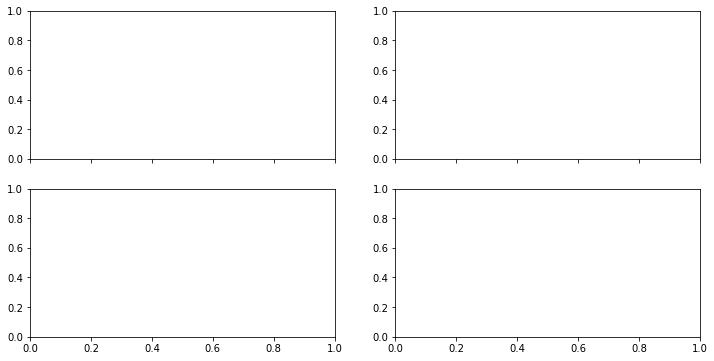

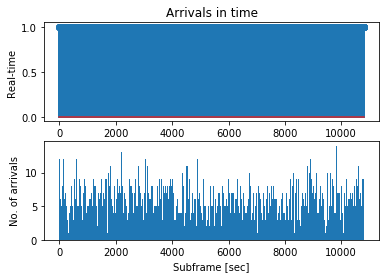

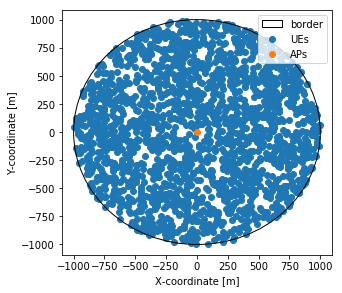

AttributeError: 'UE' object has no attribute 'mainAP'

In [332]:
### Vizualize stuff
## Vizualize arrivals in time
plt.subplots(2, 1, sharex=True, sharey=False)
plt.subplot(2,1,1)
plt.title('Arrivals in time')
numberUEs = Parameters.system.M
validatedArrivals = []
for dev in UEs:
    validatedArrivals.extend([j for j in dev.reportArrival[0] if j > 0])
plt.stem(validatedArrivals,np.ones((len(validatedArrivals))))
plt.xlabel('Subframe [sec]')
plt.ylabel('Real-time')
# plt.xlim([0,60*10])

plt.subplot(2,1,2)
numberUEs = Parameters.system.M
plt.hist(validatedArrivals,1000)
plt.xlabel('Subframe [sec]')
plt.ylabel('No. of arrivals')
plt.show()

## Vizualize positions

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter([dev.pos[0] for dev in UEs],[dev.pos[1] for dev in UEs])
plt.scatter([ap.pos[0] for ap in APs],[ap.pos[1] for ap in APs])
centreCircle = plt.Circle((0,0),Parameters.system.cellRadius,color="k",fill=False)
ax.add_patch(centreCircle)
plt.xlabel('X-coordinate [m]')
plt.ylabel('Y-coordinate [m]')
plt.legend(['border','UEs','APs'],loc='upper right')
plt.subplots_adjust(left=0.2, right=.95, bottom=0.1, top=.95)
plt.savefig('cellLayout.eps')
plt.savefig('cellLayout.png')
plt.show()


## CDF of distances to main APs and to all APs
plt.subplots(2, 2, sharex=True, sharey=False,figsize=(12,6))
distances = [dev.dist[dev.mainAP[0]] for dev in UEs]
plt.subplot(2,2,1)
y,x = np.histogram(distances,25)
plt.bar(x[0:-1]+(x[1]-x[0])/2,y/sum(y),width=(x[1]-x[0]))
plt.xlabel('Distance [m]')
plt.ylabel('CDF')

plt.subplot(2,2,2)
ycum = np.cumsum(y)
plt.plot(x[0:-1]+(x[1]-x[0])/2,[j/ycum[-1] for j in ycum])

distances = [dev.dist for dev in UEs]
distances = [j for i in distances for j in i]
plt.subplot(2,2,3)
y,x = np.histogram(distances,25)
plt.bar(x[0:-1]+(x[1]-x[0])/2,y/sum(y),width=(x[1]-x[0]))
plt.xlabel('Distance [m]')
plt.ylabel('CDF')

plt.subplot(2,2,4)
ycum = np.cumsum(y)
plt.plot(x[0:-1]+(x[1]-x[0])/2,[j/ycum[-1] for j in ycum])
plt.show()

### SF distribution
plt.subplots(figsize=(6,2))
SFs = [dev.SF for dev in UEs if dev.SF > 1]
x = [i-.5 for i in range(int(min(Parameters.lora.M)),2+int(max(Parameters.lora.M)))]
y,x = np.histogram(SFs,x) #
plt.bar(x[0:-1]+.5,y/sum(y),width=(x[1]-x[0]))
plt.xlabel('Spreading factors')
plt.ylabel('CDF')
plt.show()

postprocessing


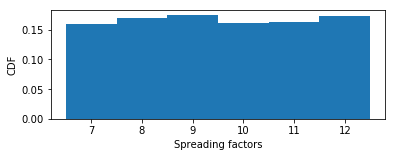

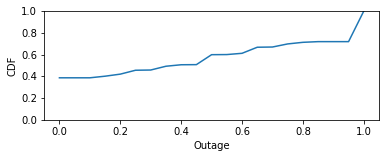

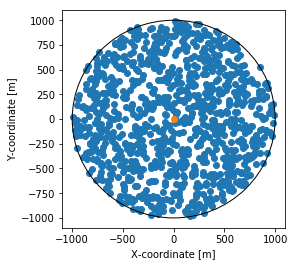

In [395]:

print('postprocessing')
# print(len([0]))
# [i for i in ue.reportArrival[0] for ue in UEs]
# nTXs
# for ue in UEs:
nTXs = [len([i for i in ue.reportArrival[0] if i]) for ue in UEs]
succes = [sum([1 if all([any([1 if i else 0 for i in j]) for j in k]) else 0 for k in ue.reportSucces]) for ue in UEs]
# nDevs = len([len([i for i in ue.reportArrival[0] if i]) for ue in UEs])
# nDevs = len(UEs)
outage = [1-succes[i]/nTXs[i] for i in range(0,len(nTXs)) if nTXs[i]]
# print(nDevs)


plt.subplots(figsize=(6,2))
SFs = [dev.SF for dev in UEs if dev.SF > 1]
x = [i-.5 for i in range(int(min(Parameters.lora.M)),2+int(max(Parameters.lora.M)))]
y,x = np.histogram(SFs,x) #
plt.bar(x[0:-1]+.5,y/sum(y),width=(x[1]-x[0]))
plt.xlabel('Spreading factors')
plt.ylabel('CDF')
plt.show()

bins = 20
plt.subplots(figsize=(6,2))
y,x = np.histogram(outage,[i/bins-1/bins/2 for i in range(0,bins+2)]) #
# plt.bar(x[0:-1]+(x[1]-x[0])/2,y/sum(y),width=(x[1]-x[0]))
plt.plot(x[0:-1]+(x[1]-x[0])/2,np.cumsum(y)/sum(y))
plt.xlabel('Outage')
plt.ylabel('CDF')
plt.ylim([0,1])
plt.show()

## Vizualize positions

fig, ax = plt.subplots(figsize=(4,4))
centreCircle = plt.Circle((0,0),Parameters.system.cellRadius,color="k",fill=False)
ax.add_patch(centreCircle)

plt.scatter([dev.pos[0] for dev in UEs],[dev.pos[1] for dev in UEs])
plt.scatter([ap.pos[0] for ap in APs],[ap.pos[1] for ap in APs])
plt.xlabel('X-coordinate [m]')
plt.ylabel('Y-coordinate [m]')
plt.show()

In [87]:
x = [True, True, True, False, True, False, False, False, False, False, False, True, True]
# x = [1 if x[i] else 0 for i in range(0,len(x))]
consecutive_one(x)

3

In [731]:
class res:

    def __init__(self):
        self.nUEs = 0
        self.nAPs = 0
        self.nTXs = []
        self.succes = []
        self.outage = []


def interprocessing(UEs,APs):
    
    result = res()
    
    result.nUEs = len(UEs)+1
    result.nAPs = len(APs)+1
    result.UEpos = [[dev.pos[0] for dev in UEs],[dev.pos[1] for dev in UEs]]
    result.APpos = [[ap.pos[0] for ap in APs], [ap.pos[1] for ap in APs]]
    result.SFs = [dev.SF for dev in UEs if dev.SF > 1]
    
    result.nTXs = [len([i for i in ue.reportArrival[0] if i]) for ue in UEs]
    result.nCapture = [sum([1 if all([any([1 if i else 0 for i in j]) for j in k]) else 0 for k in ue.reportCapture]) for ue in UEs]
    result.nPreSucces = [sum([1 if all([any([1 if i else 0 for i in j]) for j in k]) else 0 for k in ue.reportPreSucces]) for ue in UEs]
    result.nSucces = [sum([1 if all([any([1 if i else 0 for i in j]) for j in k]) else 0 for k in ue.reportSucces]) for ue in UEs]
    result.preOutage = [1-result.nPreSucces[i]/result.nTXs[i] for i in range(0,len(result.nTXs)) if result.nTXs[i]]
    result.outage = [1-result.nSucces[i]/result.nTXs[i] for i in range(0,len(result.nTXs)) if result.nTXs[i]]
    
    
    
    return result

Note on ATPBAR: Check this if you get the error messsage "Failed to display Jupyter Widget...".
You must enable widgets for the atpbar to work!
Eg. if using conda, type in Anaconda prompt "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Now, update the browser page so it reconnects to the kernel and laods the new setting.

The widgets need the nodejs library installed "conda install nodejs" / "pip install nodejs"
Still having trouble? Try "trusting" the notebook (file->"trust notebook") in jupyter and make sure jupyter and the required libraries are up-to-date.

In [753]:
# Post-processing parameters
# nbins = 10000

# PP variables
results = []

# Simulator parameters
Parameters.REPS = 10
Parameters.traffic.lambdaD = 1/(60*10)
Parameters.simulationLen = np.floor(Parameters.maxReports/3)*1/Parameters.traffic.lambdaD
# A = [1,2,3,4,5,6,7,8,9,10]
A = [1,2,3,4,5]
# M = [5,25,50,100,150,200,250,300,400,500,600,700,800,900,1000]
# M = [int(m*8) for m in M]
M = [10, 50, 100, 500, 1000, 2500, 5000, 7500, 10000]
REPS = [min(int(np.ceil(max(M)/m)*2),200) for m in M]
# endProgress = (Parameters.REPS-1)
# endTotalProgres = ((len(A))*(Parameters.REPS))
# for a in atpbar(A, name='Total progress'):
#     for rep in atpbar(range(0,Parameters.REPS), name=str(Parameters.REPS)+' repetitions for '+str(a)+' GWs'):
#         aidx = np.where([k == a for k in A])[0][0]
for mn in atpbar(M, name='Total progress'):    
    results.append([])
    aidx = np.where([k == mn for k in M])[0][0]
    for rep in atpbar(range(0,REPS[aidx]), name=str(REPS[aidx])+' repetitions for '+str(mn)+' UEs'):
        
            
        Parameters.system.A = 1 # number of APs
        Parameters.system.M = mn # number of UEs
        

        
        ### Generate arrivals
        UEs, APs = generateTraffic(Parameters)
        
        # Simulate LoRa devices transmitting
        UEs, APs = simLoRa(UEs, APs, Parameters)

        ### Intermidiate processing of results
        results[aidx].append(interprocessing(UEs,APs))

print('done')

done


In [730]:
print(UEs[3].reportSucces)
[1 if all([any([1 if i else 0 for i in j]) for j in k]) else 0 for k in UEs[3].reportPreSucces]

[[[[]]], [[[0]]], [[[0]]], [[[0]]], [[[0]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]], [[[]]]]


[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

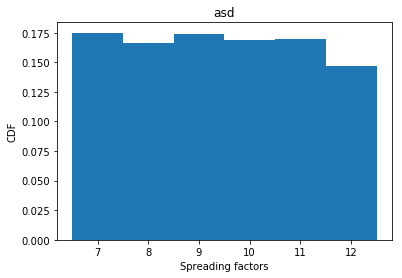

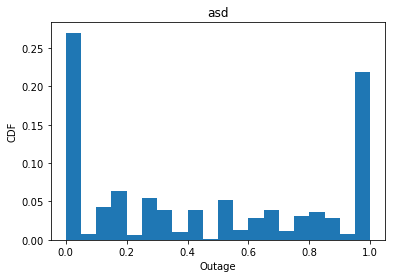

5.9125 0.57419375


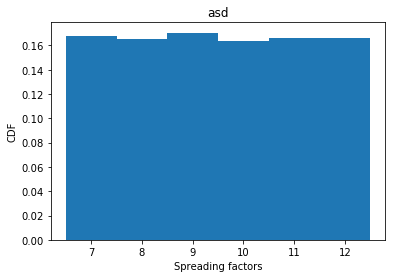

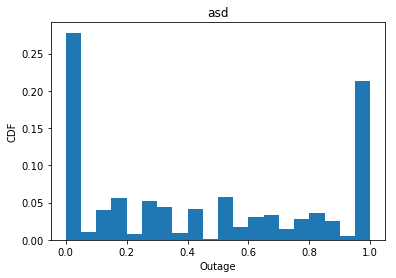

6.0292 0.11513136


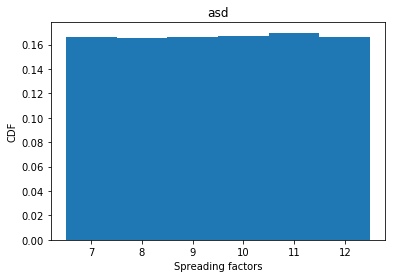

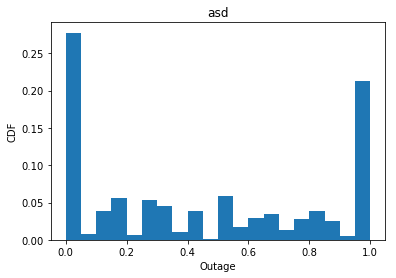

5.98225 0.0608164375


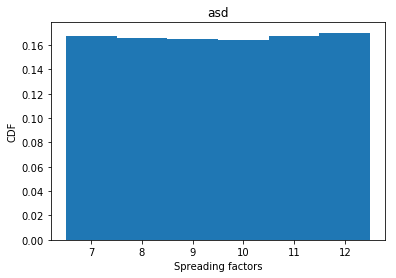

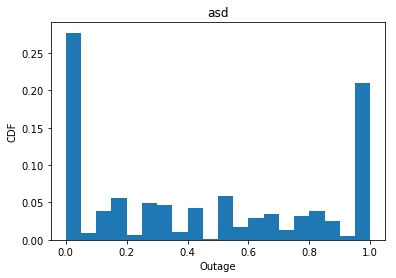

5.99225 0.0080270375


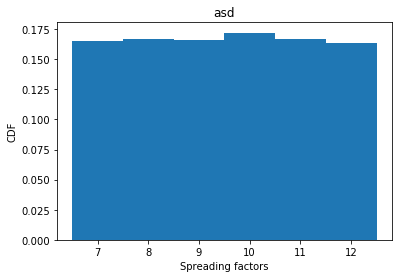

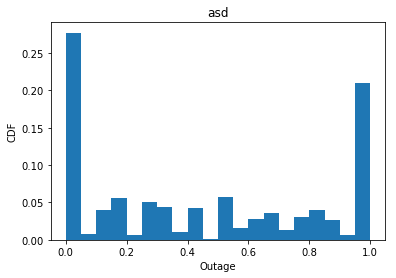

6.00525 0.0038562875


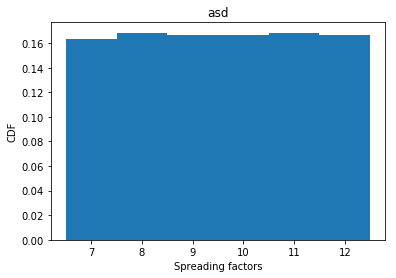

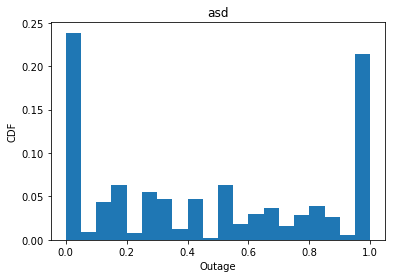

5.98555 0.0021254175


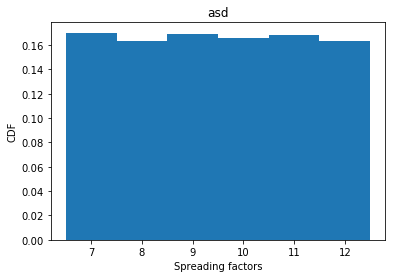

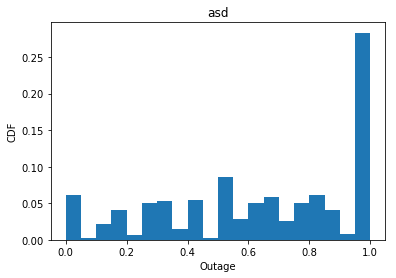

5.98345 0.0004048875


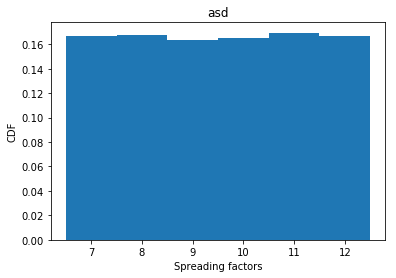

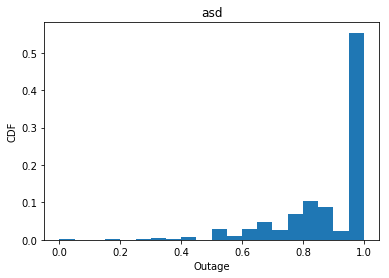

6.03216666667 0.000115416666667


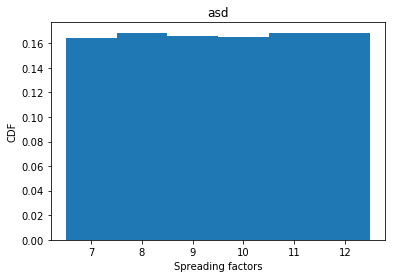

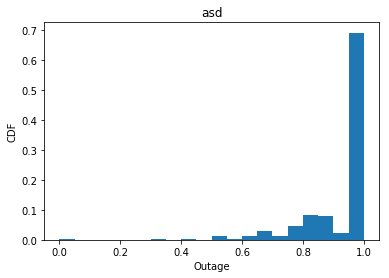

5.99395 3.19225e-05
5.99072962963 0.00107690239369
0.0849669462963 0.0313068771062
[0.45429545543523503, 0.44737988399940304, 0.4492017354149892, 0.44845813744243784, 0.44954130442568718, 0.46476442977705318, 0.63352281177511582, 0.88159830678336526, 0.93110340835064931]


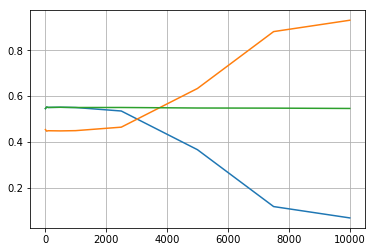

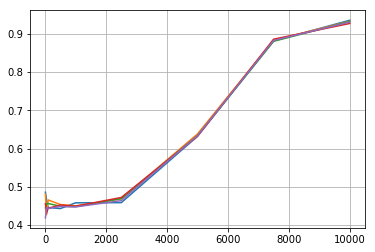

In [748]:
bins = 20
nTXsMean = []
nTXsVar = []
preOutMean = []
OutMean = []
Out2Mean = []
OutSF = [[],[],[],[],[],[]]
CaptureMean = []
for result in results:
    # Spreading factor distribution
    SFs = [i for r in result for i in r.SFs]
    x = [i-.5 for i in range(int(min(Parameters.lora.M)),2+int(max(Parameters.lora.M)))]
    ySF,x = np.histogram(SFs,x,density = True)
    
    plt.bar(x[0:-1]+.5,ySF,width=(x[1]-x[0]))
    plt.xlabel('Spreading factors')
    plt.ylabel('CDF')
    plt.title('asd')
    plt.show()
    
    # Outage
    Outs = [i for r in result for i in r.outage]
    x = [i/(bins) for i in range(0,bins+1)]
    yOut,x = np.histogram(Outs,x)
    Outs2 = [np.mean(r.outage) for r in result]
    
    # preOutage
    preOut = [i for r in result for i in r.preOutage]
    preOutMean.append(np.mean(preOut))
    
    # Capture
    Capture = [r.nCapture[i]/r.nTXs[i] for r in result for i in range(0,len(r.nCapture)) if r.nTXs[i]]
    CaptureMean.append(np.mean(Capture))
#     nTX = [i for r in result for i in r.nTXs]
    
#     Outs = [i for r in result for i in r.outage]
    
    
    plt.bar(x[0:-1]+(x[1]-x[0])/2,[i/sum(yOut) for i in yOut],width=(x[1]-x[0]))
    plt.xlabel('Outage')
    plt.ylabel('CDF')
    plt.title('asd')
    plt.show()
    
    OutMean.append(np.mean(Outs))
    Out2Mean.append(np.mean(Outs2))
    
    #SF based outage
    for j in range(7,12):
        OutSF[j-7].append(np.mean([Outs[i] for i in range(0,len(Outs)) if SFs[i] == j]))
    
    
    # Number of transmissions (to test for sufficient no. reps and sim. length!)
    nTXs = [np.mean(r.nTXs) for r in result]
    nTXsMean.append(np.mean(nTXs))
    nTXsVar.append(np.var(nTXs))
    print(nTXsMean[-1],nTXsVar[-1])
    
print(np.mean(nTXsMean),np.var(nTXsMean))
print(np.mean(nTXsVar),np.var(nTXsVar))
print(OutMean)

plt.figure()
plt.plot(M,[1-i for i in OutMean])
# plt.plot(M,Out2Mean)
# plt.plot(M,CaptureMean)
plt.grid()
plt.show()
plt.figure()
for j in range(7,12):
    plt.plot(M,OutSF[j-7])
plt.grid()
plt.show()

[[]]

In [212]:
print('postprocessing')
bins = 20
all_out = []
all_sf = []
for result in results:
    nTXs = result.nTXs
    succes = result.succes
    # nDevs = len([len([i for i in ue.reportArrival[0] if i]) for ue in UEs])
    # nDevs = len(UEs)
    outage = result.outage
    # print(nDevs)


    plt.subplots(figsize=(6,2))
    SFs = result.SFs
    x = [i-.5 for i in range(int(min(Parameters.lora.M)),2+int(max(Parameters.lora.M)))]
    ySF,x = np.histogram(SFs,x,density = True) #
    all_sf.append(ySF)

    
    plt.subplots(figsize=(6,2))
    x = [i/(bins) for i in range(0,bins+1)]
    yOut,x = np.histogram(outage,x) #
    all_out.append(yOut)

avg_out = []
avg_sf = []
x = [i/(bins) for i in range(0,bins+1)]
fig, axs = plt.subplots(2,3)
for i in range(0,int(np.ceil((len(results)-1)/Parameters.REPS))):
    avg_out.append(np.sum(all_out[i*Parameters.REPS:(i+1)*Parameters.REPS-1],axis=0))
    print(np.array([j/sum(avg_out[i]) for j in avg_out[i]]))
    print(x)
    plt.bar(x+(x[1]-x[0])/2,np.array([j/sum(avg_out[i]) for j in avg_out[i]]),width=(x[1]-x[0]))
# print(np.sum(all_out[0:Parameters.REPS-1],axis=0))
# print(np.sum(all_out[Parameters.REPS:2*Parameters.REPS-1],axis=0))
# print(np.sum(all_out[2*Parameters.REPS:3*Parameters.REPS-1],axis=0))


plt.show()

#     ## Vizualize individual results
#     plt.bar(x[0:-1]+.5,y,width=(x[1]-x[0]))
#     plt.xlabel('Spreading factors')
#     plt.ylabel('CDF')
#     plt.show()
#     plt.bar(x[0:-1]+(x[1]-x[0])/2,[i/sum(y) for i in y],width=(x[1]-x[0]))
#     plt.xlabel('Outage')
#     plt.ylabel('CDF')
#     plt.show()
#     fig, ax = plt.subplots(figsize=(4,4))
#     centreCircle = plt.Circle((0,0),Parameters.system.cellRadius,color="k",fill=False)
#     ax.add_patch(centreCircle)
#     plt.scatter(result.UEpos[0],result.UEpos[1])
#     plt.scatter(result.APpos[0],result.APpos[1])
#     plt.xlabel('X-coordinate [m]')
#     plt.ylabel('Y-coordinate [m]')
#     plt.show()


postprocessing


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[ 0.14444444  0.04444444  0.06666667  0.07777778  0.06666667  0.15555556
  0.08888889  0.08888889  0.07777778  0.02222222  0.07777778  0.03333333
  0.03333333  0.01111111  0.01111111  0.          0.          0.          0.
  0.        ]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


TypeError: can only concatenate list (not "float") to list

In [175]:
a = []
a.append([1,2,3])
a.append([3,4,5])

np.sum(a,axis=0)

array([4, 6, 8])